In [1]:
%matplotlib qt4
%matplotlib inline

# DM3 Translator
* This file is used to translate the raw DM3 data file into standard H5 file. 

* The data will be initially processed and stored in the same file for future analysis. 
 - The process includes: ZLP alignment, Thickness computing, ZLP substraction. 
 - Please be aware that the data is limited to low-loss data so far. <br>
 - If the raw data is core-loss signal, please include additional low-loss data for the ZLP alignment.

# Import Software:
* Standard distribution (include numpy, scipy, matplotlib, sci-kit learn).
* **hyperspy** : can load and process DM3 data directly. (import hyperspy.api, not hyperspy)
* **pycroscopy** : mainly used here for plotting purposes only. 
* **hyperspy_tools** : to extract EELS zlp.

In [2]:
#Import packages

# Ensure that this code works on both python 2 and python 3
from __future__ import division, print_function, absolute_import, unicode_literals

# basic numeric computation:
import numpy as np

# basic system operation:
import os

# The package used for creating and manipulating HDF5 files:
import h5py
import hyperspy.api as hs

# To extract EELS ZLP, put 'eels.py' from hyperspy_tools in the python path and then import here:
from eels import extract_ZLP

# Plotting and visualization:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

# finally import pycroscopy:
import pycroscopy as px

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load DM3 data:
* Use **hyperspy** to read DM3 data.
* Reshape the data as h5 file required.
## Tips:
* The 'np.reshape' will reshape the matrix acoording to the C memory order, i.e. the most rapidly changing index comes last: (k,j,i)
* The h5 file for pycroscopy requires the 3D EELS data (i,j,k) to be flattened as 2D (i*j, k) in the C memory order as well, i.e. the order of row in the flattened data is [0,0],[0,1]...[0,N-1],[1,0],[1,1] ...

In [3]:
folder_path=''
file_name='EELS Spectrum Image.dm3'

folder_path = 'D:/Books/research/IMAGE/20180110_TMD/'
folder_name = '150_3'
file_name = folder_path + folder_name + '/EELS Spectrum Image.dm4'
raw = hs.load(file_name,signal_type='EELS')
#raw = hs.load(folder_path+file_name,signal_type='EELS')
data = raw.data
np.shape(data)
raw.metadata

D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):


(22, 22, 2048)

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EELS
│       │       ├── aperture_size = 5.0
│       │       ├── collection_angle = 52.083333333333336
│       │       ├── frame_number = 1
│       │       └── spectrometer = GIF Abruzzi
│       ├── Stage
│       │   ├── tilt_alpha = 1.7100000381469727
│       │   ├── x = -0.055094000000000004
│       │   ├── y = 0.069595796875
│       │   └── z = -0.051299
│       ├── acquisition_mode = STEM
│       ├── beam_current = 0.0
│       ├── beam_energy = 200.0
│       ├── camera_length = 20.0
│       ├── convergence_angle = 4.5
│       ├── magnification = 15000000.0
│       └── microscope = []
├── General
│   ├── original_filename = EELS Spectrum Image.dm4
│   └── title = EELS Spectrum Image
└── Signal
    ├── Noise_properties
    │   └── Variance_linear_model
    │       ├── gain_factor = 1.0
    │       └── gain_offset = 0.0
    ├── binned = True
    ├── quantity = Intensity (Counts)
    └── signal_type = EELS

In [4]:
count = 0
data_shape = np.shape(data)
ind_mat = np.zeros(data_shape)
for (ind1,ind2,ind3), val in np.ndenumerate(data):
    ind_mat[ind1,ind2,ind3] = count
    count += 1
#print(np.shape(data))

h5_data = np.reshape(data,(-1,data_shape[2]))
h5_ind = np.reshape(ind_mat,(-1,data_shape[2]))
##present the ordering:
#make a function to transfer count of the memory order to 3D position.
#def getindex(number):
#    id1 = number//(data_shape[2]*data_shape[1])
#    res1 = number%(data_shape[2]*data_shape[1])
#    id2 = res1//data_shape[2]
#    id3 = res1 - id2*data_shape[2]
#    return (id1,id2,id3)

#for i in range(30):
#    print(getindex(h5_ind[i,0]))


# Prepare Ancillary Data and Translate into H5 file:
* Create the new file path.
* Specify the spectroscopic axis: minimum of the axis, and dispersion
* Translate the data into h5 file using **NumpyTranslator**

In [5]:
h5_path = os.path.join(folder_path, file_name[:-4] + '.h5')
print('The h5 file will be saved in the following path:')
print(h5_path)

image_cal = raw.original_metadata.ImageList.TagGroup0.ImageData.Calibrations.Dimension
pos_cal = image_cal.TagGroup0
spec_cal = image_cal.TagGroup2
print(image_cal)

# Generate the x / spectroscopic axis:
pos_pixel_size = pos_cal.Scale
pos_units = pos_cal.Units


spec_pixel_size = spec_cal.Scale
spec_min = (0-spec_cal.Origin)*spec_cal.Scale
spec_units = spec_cal.Units
spec_vec = np.linspace(spec_min, spec_min+spec_pixel_size*(data_shape[2]-1), data_shape[2])


# Generate attributes dictionary:
parm_dict=dict()
tem = raw.metadata.Acquisition_instrument.TEM
parm_dict['beam_energy'] = tem.beam_energy
parm_dict['convergence_angle'] = tem.convergence_angle
parm_dict['EELS_collection_angle']=tem.Detector.EELS.collection_angle
parm_dict['num_rows']=data_shape[0]
parm_dict['num_cols']=data_shape[1]
parm_dict['spec_length']=data_shape[2]
parm_dict['spec_axis']=spec_vec
parm_dict['spec_pixel_size']=spec_pixel_size
parm_dict['spec_unit']=spec_units
parm_dict['spatial_pixel_size']=pos_pixel_size
parm_dict['spatial_unit']=pos_units
for key in parm_dict:
    print(key, ':', parm_dict[key])

The h5 file will be saved in the following path:
D:/Books/research/IMAGE/20180110_TMD/150_3/EELS Spectrum Image.h5
├── TagGroup0
│   ├── Origin = 0.0
│   ├── Scale = 0.6330757737159729
│   └── Units = nm
├── TagGroup1
│   ├── Origin = 0.0
│   ├── Scale = 0.6330757737159729
│   └── Units = nm
└── TagGroup2
    ├── Origin = 200.0
    ├── Scale = 0.05000000074505806
    └── Units = eV

beam_energy : 200.0
convergence_angle : 4.5
EELS_collection_angle : 52.083333333333336
num_rows : 22
num_cols : 22
spec_length : 2048
spec_axis : [-10.00000015  -9.95000015  -9.90000015 ...  92.25000137  92.30000138
  92.35000138]
spec_pixel_size : 0.05000000074505806
spec_unit : eV
spatial_pixel_size : 0.6330757737159729
spatial_unit : nm


In [6]:
tran = px.io.NumpyTranslator()
h5_path = tran.translate(h5_path, h5_data, data_shape[0], data_shape[1], 
                         qty_name='Count', data_unit='', spec_name='Energy Loss',
                         spec_unit='eV', spec_val=spec_vec, spatial_unit='um', 
                         data_type='STS',translator_name='ASC', parms_dict=parm_dict)

## Process the raw data:
We will initially process the raw data from DM3 file for future analysis. Please be aware that the data is limited to low-loss data so far. If the raw data is core-loss signal, please include additional low-loss data for the ZLP alignment.
 - The initial process includes:
  - ZLP alignment (this file is limited to low-loss data)
  - Thickness computing
  - ZLP substraction

**1. Align ZLP with subpixel accuracy on.**

D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):



Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	0.000
std:	0.008

min:	-0.049
Q1:	0.001
median:	0.001
Q3:	0.001
max:	0.001


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Text(0,0.5,'ZLP Positions')

[]

(array([], dtype=float64), <a list of 0 Text yticklabel objects>)

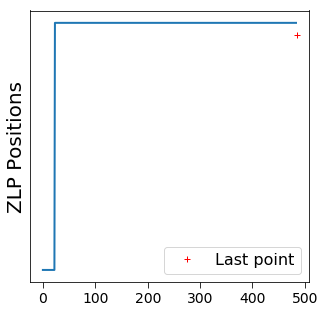

In [8]:
raw.align_zero_loss_peak(subpixel=True)
new_axes = raw.axes_manager['Energy loss']
new_spec_vec = np.linspace(new_axes.offset, new_axes.offset+new_axes.scale*(new_axes.size-1), new_axes.size)
zlp_pos = raw.estimate_zero_loss_peak_centre()
zlp_sort = np.sort(zlp_pos,axis=None)
plt.plot(zlp_sort)
plt.ylabel('ZLP Positions', fontsize=20)
plt.gca().set_yticks([])
plt.yticks()
plt.plot(np.shape(zlp_sort)[0],0,'r+',label='Last point')
plt.legend()

D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):
D:\Anaconda3\lib\site-packages\hyperspy\signal.py:1990: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(navigator().dtype, complex):
D:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mp

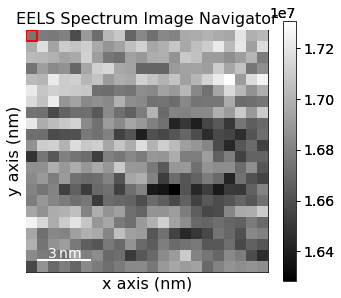

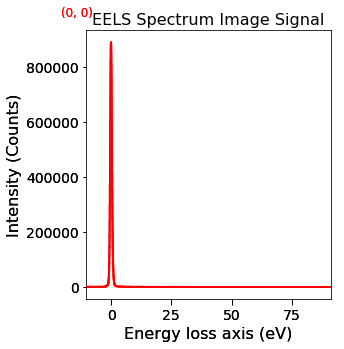

In [9]:
raw.plot()

**2. Compute the thickness.**

In [10]:
thickness = raw.estimate_thickness(0.01).data
print(thickness.shape)

D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):


(22, 22)


**3. Extract ZLP signal and get the inelastic signal.**<br>

* Remember to translate the data into the format pycroscopy required

In [11]:
zlp, sig = extract_ZLP(raw,range_factor=(-10, 6),return_inelastic=True,print_output=True)
zlp_data = np.reshape(zlp.data,(-1,zlp.data.shape[2]))
sig_data = np.reshape(sig.data,(-1,sig.data.shape[2]))

D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):


Fitting initial Gaussian to determine fitting range


A Jupyter Widget


Mean HWHM of ZLP is 0.42 eV
Fitting Signal in range (-10, 6)*HWHM...


A Jupyter Widget


Fit results:
Components	Parameter	Value
Gaussian
		A	1.17848e+07
		centre	0.0424637
		sigma	0.383751
Lorentzian
		A	4.15509e+06
		centre	-0.0679982
		gamma	0.333129

Calculating inelastic portion of spectrum:


D:\Anaconda3\lib\site-packages\hyperspy\misc\math_tools.py:61: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(number, np.float)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Calculating ZLP portion of spectrum:


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

"Residual" mean: nan
"Residual" std dev: nan


In [17]:
raw.original_metadata.ImageList.TagGroup0.ImageData.Calibrations.Dimension

├── TagGroup0
│   ├── Origin = 0.0
│   ├── Scale = 0.6330757737159729
│   └── Units = nm
├── TagGroup1
│   ├── Origin = 0.0
│   ├── Scale = 0.6330757737159729
│   └── Units = nm
└── TagGroup2
    ├── Origin = 200.0
    ├── Scale = 0.05000000074505806
    └── Units = eV

In [73]:
# Next, impute the missing values
test = deepcopy(sig)
t = test.data
sp = np.shape(test.data)
for i in range(sp[0]):
    for j in range(sp[1]):
        for k in range(sp[2]):
            if np.isnan(test.data[i,j,k]):
                print('Found nan! ({},{},{})'.format(i,j,k))

Found it! (15,11,143)


Found it! (15,14,222)


In [95]:
t[np.isnan(t)]=0
sig.plot()

# Load and write H5 data:
* Use **ioHDF5** to read/write H5 data.
* Use **MicroDataset** and **MicroDatagroup** to manage the data and build the tree structure.
    - Tips: Remember to assign the original `Attibute` data and `Ancillary` data.

In [13]:
# Open the file
hdf = px.ioHDF5(h5_path)
h5_file = hdf.file
h5_main = h5_file['Measurement_000/Channel_000/Raw_Data']
h5_pos_ind = h5_file['Measurement_000/Channel_000/Position_Indices']
h5_pos_val = h5_file['Measurement_000/Channel_000/Position_Values']
h5_spec_ind = h5_file['Measurement_000/Channel_000/Spectroscopic_Indices']
h5_spec_val = h5_file['Measurement_000/Channel_000/Spectroscopic_Values']

# Visualize the tree structure in the file
print('Tree structure within the file:')
px.hdf_utils.print_tree(h5_file)

#new_pos_ind, new_pos_val = px.io.translators.utils.build_ind_val_dsets([data_shape[0], data_shape[1]], is_spectral=False,labels=['Y', 'X'], 
#                                                                       units=[pos_units, pos_units],verbose=False)

new_spec_inds, new_spec_vals = px.io.translators.utils.build_ind_val_dsets([new_axes.size], is_spectral=True,
                                                                           labels=['Energy loss'], units=[new_axes.units], 
                                                                           verbose=False)

# Create three main datasets with four ancillary datasets
ds_proc = px.MicroDataset('Processed_Data', sig_data, dtype=h5_main.dtype)
px.hdf_utils.copy_main_attributes(h5_main, ds_proc)
ds_pos_ind = px.MicroDataset('Position_Indices', h5_pos_ind[()], dtype=h5_pos_ind.dtype)
px.hdf_utils.copy_main_attributes(h5_pos_ind, ds_pos_ind)
ds_pos_val = px.MicroDataset('Position_Values', h5_pos_val[()], dtype=h5_pos_val.dtype)
px.hdf_utils.copy_main_attributes(h5_pos_val, ds_pos_val)
ds_spec_ind = px.MicroDataset('Spectroscopic_Indices', new_spec_inds[()], dtype=h5_spec_ind.dtype)
px.hdf_utils.copy_main_attributes(h5_spec_ind, ds_spec_ind)
ds_spec_val = px.MicroDataset('Spectroscopic_Values', np.array([new_spec_vec]), dtype=h5_spec_val.dtype)
px.hdf_utils.copy_main_attributes(h5_spec_val, ds_spec_val)

ds_zlp = px.MicroDataset('Zero_Loss_Peak', zlp_data, dtype=h5_main.dtype)
px.hdf_utils.copy_main_attributes(h5_main, ds_zlp)
    
ds_thickness = px.MicroDataset('Thickness', thickness, dtype=h5_main.dtype)



# Add the datasets to the Group
#source_dset_name = h5_main.parent.name.split('/')[-1]
subtree_root_path = h5_main.parent.name[1:]

h5_grp = px.MicroDataGroup('Processed', subtree_root_path)
print('The dataset will be appended to the H5 file under the group:', subtree_root_path+'/Processed')

h5_grp.addChildren([ds_proc, ds_zlp, ds_thickness, ds_pos_ind, ds_pos_val, ds_spec_ind, ds_spec_val])

Tree structure within the file:
/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Spectroscopic_Indices
Measurement_000/Channel_000/Spectroscopic_Values
The dataset will be appended to the H5 file under the group: Measurement_000/Channel_000/Processed


# Write to H5 file and get reference to access the written objects:

In [14]:
h5_clust_refs = hdf.writeData(h5_grp, print_log=True)
ref_sig = px.hdf_utils.getH5DsetRefs(['Processed_Data'], h5_clust_refs)[0]
ref_zlp = px.hdf_utils.getH5DsetRefs(['Zero_Loss_Peak'], h5_clust_refs)[0]
ref_pos_ind = px.hdf_utils.getH5DsetRefs(['Position_Indices'], h5_clust_refs)[0]
ref_pos_val = px.hdf_utils.getH5DsetRefs(['Position_Values'], h5_clust_refs)[0]
ref_spec_ind = px.hdf_utils.getH5DsetRefs(['Spectroscopic_Indices'], h5_clust_refs)[0]
ref_spec_val = px.hdf_utils.getH5DsetRefs(['Spectroscopic_Values'], h5_clust_refs)[0]

px.hdf_utils.print_tree(h5_file)

Created group /Measurement_000/Channel_000/Processed
Writing attribute: machine_id with value: LakerHoo-PC
Writing attribute: timestamp with value: 2018_01_30-15_02_33
Wrote attributes to group: Processed 

Created Dataset /Measurement_000/Channel_000/Processed/Processed_Data
Writing attribute: quantity with value: Count
Wrote Attributes of Dataset Processed_Data 

Writing attribute: units with value: 
Wrote Attributes of Dataset Processed_Data 

Created Dataset /Measurement_000/Channel_000/Processed/Zero_Loss_Peak
Writing attribute: quantity with value: Count
Wrote Attributes of Dataset Zero_Loss_Peak 

Writing attribute: units with value: 
Wrote Attributes of Dataset Zero_Loss_Peak 

Created Dataset /Measurement_000/Channel_000/Processed/Thickness
Created Dataset /Measurement_000/Channel_000/Processed/Position_Indices
Writing attribute: quantity with value: Unknown
Wrote Attributes of Dataset Position_Indices 

Writing attribute: units with value: [b'um' b'um']
Wrote Attributes of Da

# Link the two new datasets to the four `Ancillary` datasets dataset:
* These two datasets will be the `main` dataset after linking.

In [15]:
# we already got the reference to the spectroscopic values in the first few cells
#h5_spec_inds = px.hdf_utils.getAuxData(h5_main, 'Spectroscopic_Indices')[0]

px.hdf_utils.checkAndLinkAncillary(ref_sig,
                      ['Position_Indices', 'Position_Values'],
                      anc_refs=[ref_pos_ind,ref_pos_val])
px.hdf_utils.checkAndLinkAncillary(ref_sig,
                      ['Spectroscopic_Indices', 'Spectroscopic_Values'],
                      anc_refs=[ref_spec_ind, ref_spec_val])

px.hdf_utils.checkAndLinkAncillary(ref_zlp,
                      ['Position_Indices', 'Position_Values'],
                      anc_refs=[ref_pos_ind,ref_pos_val])
px.hdf_utils.checkAndLinkAncillary(ref_zlp,
                      ['Spectroscopic_Indices', 'Spectroscopic_Values'],
                      anc_refs=[ref_spec_ind, ref_spec_val])

# Verify the new H5 file:
* We will perform a map of certain eV to check this file. (remember to set the check point in EELS)
* Then we will plot a EELS signal at certain spatial point. (set the spatial point)

/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Processed
Measurement_000/Channel_000/Processed/Position_Indices
Measurement_000/Channel_000/Processed/Position_Values
Measurement_000/Channel_000/Processed/Processed_Data
Measurement_000/Channel_000/Processed/Spectroscopic_Indices
Measurement_000/Channel_000/Processed/Spectroscopic_Values
Measurement_000/Channel_000/Processed/Thickness
Measurement_000/Channel_000/Processed/Zero_Loss_Peak
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Spectroscopic_Indices
Measurement_000/Channel_000/Spectroscopic_Values


(<matplotlib.image.AxesImage at 0x19e35080>,
 <matplotlib.colorbar.Colorbar at 0x19e35048>)

Text(0.5,1,'Raw signal map at 28.5 eV')

Text(0.5,0,'X')

Text(0,0.5,'Y')

Text(0.5,1,'Raw EELS at a single pixel: (11.0,11.0)')

Text(0.5,0,'Energy Loss (eV)')

Text(0,0.5,'Counts')

[]

(<matplotlib.image.AxesImage at 0x19e7b4a8>,
 <matplotlib.colorbar.Colorbar at 0x19ec05f8>)

Text(0.5,1,'Thickness map at 28.5 eV')

Text(0.5,0,'X')

Text(0,0.5,'Y')

Text(0.5,1,'Inelastic EELS signal at : (11.0,11.0)')

Text(0.5,0,'Energy Loss (eV)')

Text(0,0.5,'Counts')

[]

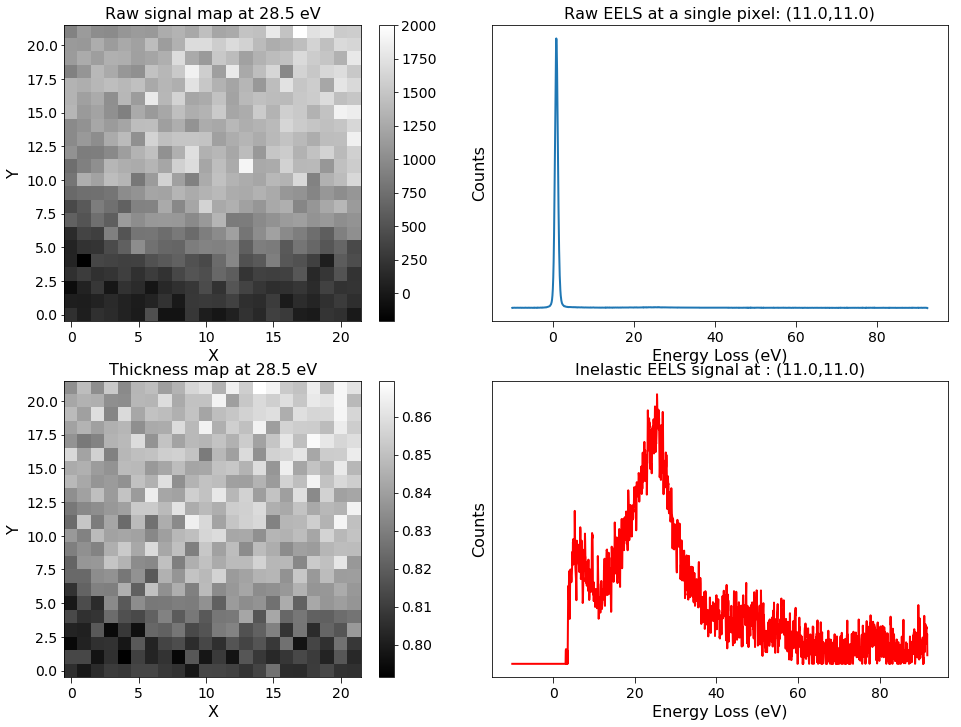

In [16]:
with h5py.File(h5_path, mode='r') as h5_file:
    # See if a tree has been created within the hdf5 file:
    px.hdf_utils.print_tree(h5_file)

    h5_proc = h5_file['Measurement_000/Channel_000/Processed/Processed_Data']
    h5_thick = h5_file['Measurement_000/Channel_000/Processed/Thickness'] 
    h5_main = h5_file['Measurement_000/Channel_000/Raw_Data']
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    
    ## 1st row for Plot Raw_Data
    # set check point in EELS to do the map:
    spec_point = 28.5
    data_point = (spec_point-spec_min)//spec_pixel_size + 1
    #print(data_point)
    #h5_main[()].shape
    spat_map = np.reshape(h5_main[:, data_point], (data_shape[0], data_shape[1]))
    px.plot_utils.plot_map(axes[0,0],spat_map, origin='lower')
    axes[0,0].set_title('Raw signal map at ' + str(spec_point) + ' eV')
    axes[0,0].set_xlabel('X')
    axes[0,0].set_ylabel('Y')  
    #set spatial point to check EELS:
    spat_point = [np.floor(data_shape[0]/2),np.floor(data_shape[1]/2)]
    axes[0,1].plot(np.linspace(spec_min, spec_min+spec_pixel_size*(h5_main.shape[1]-1), h5_main.shape[1]),
                 h5_main[spat_point[0]*data_shape[1]+spat_point[1]])
    axes[0,1].set_title('Raw EELS at a single pixel:'+' ('+str(spat_point[0])+','+str(spat_point[1])+')')
    axes[0,1].set_xlabel('Energy Loss (eV)')
    axes[0,1].set_ylabel('Counts');
    axes[0,1].set_yticks([])
    
    ## 2st row for Plot Processed_Data
    # set check point in EELS to do the map:
    spec_point = 28.5
    data_point = (spec_point-spec_min)//spec_pixel_size + 1
    #print(data_point)
    #h5_proc[()].shape
    #spat_map = np.reshape(h5_proc[:, data_point], (data_shape[0], data_shape[1]))
    px.plot_utils.plot_map(axes[1,0],h5_thick, origin='lower')
    axes[1,0].set_title('Thickness map at ' + str(spec_point) + ' eV')
    axes[1,0].set_xlabel('X')
    axes[1,0].set_ylabel('Y')
    #set spatial point to check EELS:
    spat_point = [np.floor(data_shape[0]/2),np.floor(data_shape[1]/2)]
    axes[1,1].plot(np.linspace(spec_min, spec_min+spec_pixel_size*(h5_proc.shape[1]-1), h5_proc.shape[1]),
                 h5_proc[spat_point[0]*data_shape[1]+spat_point[1]],'r')
    axes[1,1].set_title('Inelastic EELS signal at :'+' ('+str(spat_point[0])+','+str(spat_point[1])+')')
    axes[1,1].set_xlabel('Energy Loss (eV)')
    axes[1,1].set_ylabel('Counts');
    axes[1,1].set_yticks([])